In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import random

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation): #observation 就是 state
        actions = Q[observation]
        assert len(actions) == nA
        best_action = np.argmax(actions)
        
        # prob(best_action) = (1-eps) + eps / |A|
        # prob(other_action) = eps / |A|
        prob = np.zeros(nA)
        prob.fill(epsilon / nA)
        prob[best_action] += (1-epsilon)
#         print(prob)
        
        #check probs sum to 1
        assert np.sum(prob) == 1.0
        
        return prob
        # Implement this!
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    init_fn = lambda: np.zeros(env.action_space.n)
    
    returns_sum = defaultdict(init_fn)
    returns_count = defaultdict(init_fn)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(init_fn)
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    nA = env.action_space.n
    
    actions_cnt = np.zeros(nA)
    
    # Implement this!
    for i_episode in range(num_episodes):
        #进度条
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        state_actions = []
        
        observation = env.reset()
        
        #first-visit policy evalution
        #compute average of Q(x,a)
        for t in range(100):
    #             print_observation(observation)
                
            action_probs = policy(observation) # \pi(x)
#                 sampled_action = random.choices(list(range(1,nA + 1)), action_probs)
            sampled_action = random.choices([0,1], action_probs)[0]
            actions_cnt[sampled_action] += 1
#             print("sampled_action is ", sampled_action)
#             print("Taking action: {}".format( ["Stick", "Hit"][action]))

            #记录每次遇到的 (state, action)
            state_actions.append((observation, sampled_action))
            observation, reward, done, _ = env.step(sampled_action)

            if done:
                assert len(state_actions) == t + 1
#                 print_observation(observation)
#                 print("Game end. Reward: {}\n".format(float(reward)))

                G = reward
                #虽然这里是 first-visit，但是对于21点，不会重复访问同一个state
                #所以这里省略了判断first visit
                for i_step in range(t, -1, -1): #backward
#                     print(i)
                    state, action = state_actions[i_step]
                    returns_sum[state][action] += G
                    returns_count[state][action] += 1
            
                    #2. empirical Q(x,a) =  (\sum Q(x,a)) /count(x,a)
                    #加速了大概10倍的样子
                    Q[state][action] = returns_sum[state][action] / returns_count[state][action]
            
                    G = discount_factor * G
                    
                break
        
        #2. empirical Q(x,a) =  (\sum Q(x,a)) /count(x,a)
#         for state in returns_sum.keys():
#             for action in range(nA):
#                 #如果发生除零，程序不会崩溃，但会warning：
#                 #ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars
#                 if returns_count[state][action] == 0:
#                     continue
#                 Q[state][action] = returns_sum[state][action] / returns_count[state][action]
    
        
    print("\naction 0, 1 分别采样了 ：", actions_cnt)
    return Q, policy

In [5]:
# Q, policy = mc_control_epsilon_greedy(env, num_episodes=5000, epsilon=0.1)

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=5000000, epsilon=0.1)

Episode 4999000/5000000.
action 0, 1 分别采样了 ： [4142434. 2232443.]


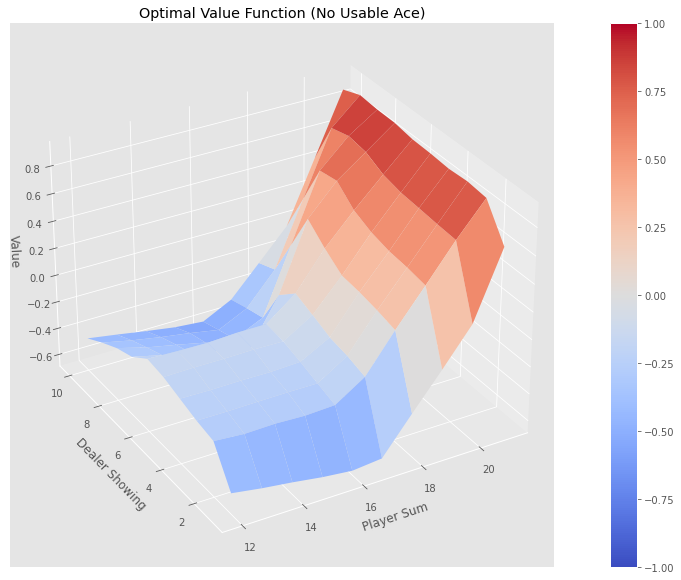

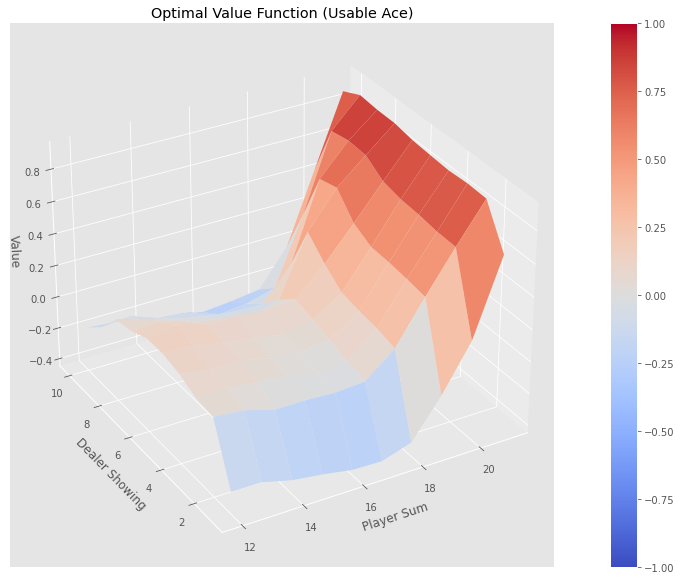

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")